In [1]:
import pandas as pd
import numpy as np
from scipy.stats import zscore

In [2]:
cp_file = '../../data/causal-priors.txt'
sde_file = '../../data/mouse_to_human_normalized5k.tsv'

cpo_df = pd.read_csv(cp_file, sep='\t', header=None, usecols=[0, 1, 2], names=['symbol', 'action', 'targetSymbol'])
cpo_df = cpo_df[cpo_df['action'].isin(['upregulates-expression', 'downregulates-expression'])]
cpo_df.reset_index(drop=True, inplace=True)
cpo_df['isUp'] = np.where(cpo_df['action'] == 'upregulates-expression', 1, -1)
cpo_df.drop(['action'], axis=1, inplace=True)

sde_df = pd.read_csv(sde_file, sep='\t', header=0, index_col=0).T
sde_df.replace(0, np.nan, inplace=True)
sde_df = pd.DataFrame(zscore(sde_df, nan_policy='omit'), index=sde_df.index, columns=sde_df.columns)
print("Files read complete...")

Files read complete...


In [3]:
cpo_df.head()

,symbol,targetSymbol,isUp
0,MAK,KLK3,1
1,XBP1,TPP1,1
2,KLF5,CXCR4,1
3,ATF3,SELE,-1
4,MYC,EIF4G1,1


In [4]:
# There may be some targetSymbols in cpo_df which are not present in sde_df
# Now remove those rows from cpo_df
cpo_df = cpo_df[cpo_df['targetSymbol'].isin(sde_df.columns)]
cpo_df.reset_index(drop=True, inplace=True)
cpo_df.head()

,symbol,targetSymbol,isUp
0,XBP1,TPP1,1
1,KLF5,CXCR4,1
2,ATF3,SELE,-1
3,MYC,EIF4G1,1
4,LDHA,HIF1A,1


In [5]:
cpo_df['targetSymbol'].unique()

array(['TPP1', 'CXCR4', 'SELE', ..., 'WNT11', 'DGKA', 'IER2'],
      dtype=object)

In [6]:
cpo_df['symbol'].unique()

array(['XBP1', 'KLF5', 'ATF3', ..., 'L1CAM', 'RCN1', 'ZNF383'],
      dtype=object)

In [7]:
cpo_grouped_df = cpo_df.groupby('symbol')['isUp'].apply(list).reset_index(name='upDownList')
cpo_grouped_df['targetList'] = cpo_df.groupby('symbol')['targetSymbol'].apply(list).reset_index(name='targetList')[
    'targetList']
cpo_grouped_df['upDownCount'] = cpo_grouped_df['upDownList'].apply(lambda x: len(x))
max_target = np.max(cpo_grouped_df['upDownCount'])
cpo_grouped_df.head()

,symbol,upDownList,targetList,upDownCount
0,A2M,[1],[STAT3],1
1,AATF,"[-1, -1]","[BAX, CTNNB1]",2
2,ABCA1,"[1, 1, -1, -1]","[NR1H2, NR1H3, GLI2, SREBF2]",4
3,ABCA3,"[1, 1, 1, 1, 1]","[SREBF1, GATA6, FOXA2, NFATC3, CEBPA]",5
4,ABCB1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[SP1, RELB, RELA, TCF7L2, FOXO1, EGR1, CEBPB, ...",10


In [8]:
a = cpo_df['targetSymbol'].unique()
b = sde_df.columns.unique()
print(len(a), len(b))

1846 2659


In [9]:
sde_df.head()

,ADORA2B,ADORA2A,ELK1,ELK3,ELK4,ABCB4,ABCB8,ABCC3,ABCC4,ABCC1,...,CASP7,RRM1,RRM2,CASP9,CASP4,CASP3,CASP6,CASP2,CASP1,NRCAM
midpoint_AAACCTGCACCCAGTG-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.926158,NaN
midpoint_AAACCTGCAGCTTAAC-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.645407,NaN,NaN,NaN,NaN,NaN
midpoint_AAACCTGGTGTGCGTC-1,NaN,NaN,NaN,0.533694,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.647571,NaN,NaN,NaN,NaN,0.389224,NaN,NaN
midpoint_AAACCTGGTTGAACTC-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
midpoint_AAACGGGAGGATGGTC-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.104636,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
n = 10_000
ranks = [(i + 0.5) / n for i in range(1, n)]
ranks

[0.00015,
 0.00025,
 0.00035,
 0.00045,
 0.00055,
 0.00065,
 0.00075,
 0.00085,
 0.00095,
 0.00105,
 0.00115,
 0.00125,
 0.00135,
 0.00145,
 0.00155,
 0.00165,
 0.00175,
 0.00185,
 0.00195,
 0.00205,
 0.00215,
 0.00225,
 0.00235,
 0.00245,
 0.00255,
 0.00265,
 0.00275,
 0.00285,
 0.00295,
 0.00305,
 0.00315,
 0.00325,
 0.00335,
 0.00345,
 0.00355,
 0.00365,
 0.00375,
 0.00385,
 0.00395,
 0.00405,
 0.00415,
 0.00425,
 0.00435,
 0.00445,
 0.00455,
 0.00465,
 0.00475,
 0.00485,
 0.00495,
 0.00505,
 0.00515,
 0.00525,
 0.00535,
 0.00545,
 0.00555,
 0.00565,
 0.00575,
 0.00585,
 0.00595,
 0.00605,
 0.00615,
 0.00625,
 0.00635,
 0.00645,
 0.00655,
 0.00665,
 0.00675,
 0.00685,
 0.00695,
 0.00705,
 0.00715,
 0.00725,
 0.00735,
 0.00745,
 0.00755,
 0.00765,
 0.00775,
 0.00785,
 0.00795,
 0.00805,
 0.00815,
 0.00825,
 0.00835,
 0.00845,
 0.00855,
 0.00865,
 0.00875,
 0.00885,
 0.00895,
 0.00905,
 0.00915,
 0.00925,
 0.00935,
 0.00945,
 0.00955,
 0.00965,
 0.00975,
 0.00985,
 0.00995,
 0.01005,


In [110]:
# # Generate Distribution
# distribution = []
# iters = 1_000
#
# for target in range(1, max_target + 1):
#     arr = []
#     for i in range(iters):
#         amr = np.mean(np.random.choice(ranks, target, replace=False))
#         imr = 1 - amr
#         arr.append(np.min([amr, imr]))
#
#     distribution.append(arr)
#
# distribution = np.array(distribution)
# distribution

In [14]:
# Another way to generate distribution
distribution = []
iters = 1_000
max_targets = 218

for target in range(1, max_targets + 1):
    arr = []
    for i in range(iters):
        amr = (np.mean(np.random.choice(n, target, replace=False)) - 0.5) / n
        imr = 1 - amr
        arr.append(np.min([amr, imr]))
    distribution.append(arr)

distribution = np.array(distribution)
distribution

array([[0.1705    , 0.0455    , 0.3655    , ..., 0.2765    , 0.0165    ,
        0.1375    ],
       [0.4145    , 0.419     , 0.4525    , ..., 0.4855    , 0.255     ,
        0.3545    ],
       [0.42016667, 0.49016667, 0.37516667, ..., 0.45583333, 0.4165    ,
        0.47883333],
       ...,
       [0.49482407, 0.48492593, 0.48493981, ..., 0.47064815, 0.48997685,
        0.46700463],
       [0.49302074, 0.46509908, 0.4971129 , ..., 0.47277189, 0.49270276,
        0.47956452],
       [0.49071101, 0.49218807, 0.49326606, ..., 0.48105505, 0.47277064,
        0.48602294]])

In [16]:
max_non_zero_genes = 0

for idx, row in sde_df.iterrows():
    cell = row.dropna()
    if len(cell) > max_non_zero_genes:
        max_non_zero_genes = len(cell)

print(max_non_zero_genes)

1483


In [18]:
# Now Calculate actual RM for each cell
for idx, row in sde_df.iterrows():
    cell = pd.DataFrame(row.index, columns=['symbol'])
    cell['zscore'] = row.values
    cell.sort_values(by=['zscore'], ascending=[False], inplace=True)
    cell.reset_index(drop=True, inplace=True)

    cell['acti_rank'] = cell.index
    cell['acti_rank'] = (cell['acti_rank'] + 0.5) / len(cell)

    cell['inhi_rank'] = 1 - cell['acti_rank']

    # Get acti_rank and inhi_rank for each targetSymbol and get the mean
    pos_rs = np.where(cpo_grouped_df[''])

    break

In [117]:
# Counting how many times the RS is less than the random distribution
for idx, row in cpo_grouped_df.iterrows():
    target = row['upDownCount']
    rs = row['RS']
    arr = distribution[target - 1]
    count = 0
    for i in arr:
        if rs >= i:
            count += 1
    cpo_grouped_df.loc[idx, 'count'] = count
    cpo_grouped_df.loc[idx, 'p-value'] = count / iters

# ---

In [49]:
some
error

NameError: name 'some' is not defined

In [91]:
for idx, row in sde_df.iterrows():
    cp_df = cpo_df.copy()

    cell_de = pd.DataFrame()
    row = row.dropna()
    cell_de['symbol'] = row.index
    cell_de['SignedP'] = row.values
    cell_de['updown'] = np.where(cell_de['SignedP'] > 0, '1', '-1')
    cell_de.sort_values(by=['updown', 'SignedP'], ascending=[False, True], inplace=True)
    cell_de.reset_index(drop=True, inplace=True)
    max_rank = len(cell_de)
    cell_de['rank'] = np.arange(1, max_rank + 1)
    cell_de['reverse_rank'] = max_rank - cell_de['rank'] + 1
    cell_de['rank'] = (cell_de['rank'] - 0.5) / max_rank
    cell_de['reverse_rank'] = (cell_de['reverse_rank'] - 0.5) / max_rank

    # Remove rows of cp_df dataframe if targetSymbol is not present in symbol column of rank_df dataframe
    cp_df = cp_df[cp_df['targetSymbol'].isin(cell_de['symbol'])]
    cp_df = cp_df.reset_index(drop=True)
    # Find the rank and reverse rank of targetsymbol
    cp_df = cp_df.merge(cell_de[['symbol', 'rank']], left_on='targetSymbol', right_on='symbol', how='left')
    cp_df['revRank'] = max_rank - cp_df['rank']
    cp_df.drop('symbol_y', axis=1, inplace=True)
    cp_df.rename(columns={'symbol_x': 'symbol'}, inplace=True)

    cp_df_grouped = cp_df.groupby('symbol')['isUp'].apply(list).reset_index(name='upDownList')
    cp_df_grouped['targetList'] = cp_df.groupby('symbol')['targetSymbol'].apply(list).reset_index(name='targetList')[
        'targetList']
    cp_df_grouped['upDownCount'] = cp_df_grouped['upDownList'].apply(lambda x: len(x))
    cp_df_grouped = cp_df_grouped[cp_df_grouped['upDownCount'] >= 3]

    # Get the ranks of each targets in targetList from cell_de dataframe and add to new column
    cp_df_grouped['targetRankList'] = cp_df_grouped.apply(
        lambda x: [cell_de[cell_de['symbol'] == target]['rank'].values[0] for target in x['targetList']], axis=1)
    cp_df_grouped['targetRevRankList'] = cp_df_grouped.apply(
        lambda x: [cell_de[cell_de['symbol'] == target]['reverse_rank'].values[0] for target in x['targetList']],
        axis=1)

    break

In [ ]:
distribution = []
for i in range(3, 200):
    ranks = np.arange(1, i + 1)
    ranks = (ranks - 0.5) / i
    distribution.append(ranks)

distribution = pd.DataFrame(distribution, index=np.arange(3, 200))
distribution.head()


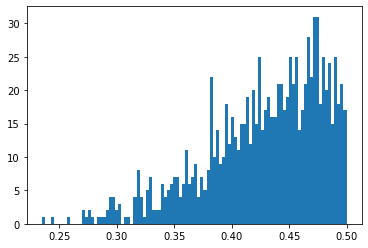

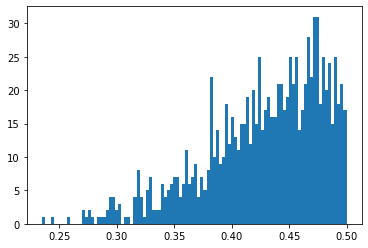

In [90]:
import matplotlib.pyplot as plt

read_dist = np.load('../../data/distribution.npy')
t1 = read_dist[10]

plt.hist(t1, bins=100)
plt.show()

# bins and count from plt.hist
count, bins, ignored = plt.hist(t1, bins=100)

# Merge count and bins
count = pd.DataFrame(count, columns=['count'])
